# PROGRAMANDO UN MLP: Predicción de cáncer


>### **Importamos librerias**

In [6]:
import torch
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics  import confusion_matrix,ConfusionMatrixDisplay

>### **Importamos el csv**

In [7]:
df = pd.read_csv('cancer_dataset.csv')

#Eliminamos la primera columna del id porque no nos sirve para el modelo de RN y depués visualizamos un poco la tabla para ver los datos
df = df.drop('id',axis=1)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


**Al ver un atributo de tipo string con dos posibles entradas unicamente, lo transformamos a variable numerica(1: Benigno, 0: Maligno) y lo pasamos a binario**

El atributo diagnosis es el que tomaremos como objetivo de predicción

In [8]:
encoder = LabelEncoder().fit_transform(df['diagnosis'])
df['diagnosis'] = tf.keras.utils.to_categorical(encoder)
df['diagnosis'].value_counts()

1.0    357
0.0    212
Name: diagnosis, dtype: int64

>### **Normalización de datos**

A continuación vamos a aplicarle a los datos un proceso de normalización, en este ejemplo probamos con una formula:
- (x - media(x)) / desviacionTipica(x)

Tomando la media y la desviacion tipica mediante torch

In [9]:
for columna in df.columns[1:]:
    tensor = torch.tensor(df[columna].values)
    df[columna] = (df[columna] - float(torch.mean(tensor))) / float(torch.std(tensor))
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.0,1.096100,-2.071512,1.268817,0.983510,1.567087,3.280628,2.650542,2.530249,2.215566,...,1.885031,-1.358098,2.301575,1.999478,1.306537,2.614365,2.107672,2.294058,2.748204,1.935312
1,0.0,1.828212,-0.353322,1.684473,1.907030,-0.826235,-0.486643,-0.023825,0.547662,0.001391,...,1.804340,-0.368879,1.533776,1.888827,-0.375282,-0.430066,-0.146620,1.086129,-0.243675,0.280943
2,0.0,1.578499,0.455786,1.565126,1.557513,0.941382,1.052000,1.362280,2.035440,0.938859,...,1.510541,-0.023953,1.346291,1.455004,0.526944,1.081980,0.854222,1.953282,1.151242,0.201214
3,0.0,-0.768233,0.253509,-0.592166,-0.763792,3.280667,3.399917,1.914213,1.450431,2.864862,...,-0.281217,0.133866,-0.249720,-0.549538,3.391291,3.889975,1.987839,2.173873,6.040726,4.930672
4,0.0,1.748758,-1.150804,1.775011,1.824624,0.280125,0.538866,1.369806,1.427237,-0.009552,...,1.297434,-1.465481,1.337363,1.219651,0.220362,-0.313119,0.612640,0.728618,-0.867590,-0.396751


Pero al evaluarla vemos que hay valores negativos y mayores a 1, asique lo normalizamos con otra formula:
- (x - valorMinimo(x)) / (valorMaximo(x) - valorMinimo(x))

In [10]:
for columna in df.columns[1:]:
    df[columna] = (df[columna] - min(df[columna])) / (max(df[columna]) - min(df[columna]))
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,...,0.620776,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
1,0.0,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878
2,0.0,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,...,0.556386,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433
3,0.0,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,...,0.248310,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711
4,0.0,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,...,0.519744,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595


>### **Separación de dataset**

Separamos csv en dos datasets, uno de entrenamiento y otro de predicción

In [11]:
x_train,x_test,y_train,y_test = train_test_split(
    df.iloc[:,1:],
    df.iloc[:,0],
    test_size= 0.25,
    shuffle= True, 
    random_state= random.randint(0,42)
    )

#Pintamos las formas simplemente para comprobar que mantienen los dos datasets la misma estructura
print(f'TRAIN:\n{x_train.shape}\n{y_train.shape}')
print(f'\nTEST:\n{x_test.shape}\n{y_test.shape}')


TRAIN:
(426, 30)
(426,)

TEST:
(143, 30)
(143,)


>### **Elección de arquitectura para nuestro MLP**

Para crear un modelo de perceptrón multicapa, hemos usado la librería de tensorflow para acceder a keras e importar un modelo llamado `Sequential`.

Es un modelo basico de red neuronal sin ninguna modificación en su arquitectura, para definir cada capa hemos escogido una instancia `Dense`. En ese objeto, tu puedes definir atributos como la cantidad de neuronas en cada capa y su funcion de activación asociada.


Como era nuestra primera red neuronal y no teniamos mucha experiencia eligiendo neuronas decidimos aplicar la regla del codo:
- Primeramente nos definimos una lista de losses en el que va a guardar la media de todos los loss de cada vez que se entrene el modelo(epochs). El loss es una funcion empleada para medir la diferencia entre las predicciones del modelo y los valores reales del conjunto de entrenamiento

- Seguidamente nos creamos un array de ints que van a representar distintos numeros de neuronas para nuestra primera capa de entrenamiento.

- Los vamos recorriendo y vamos guardando las medias de los loss de cada iteración.

- Por ultimo representamos en una gráfica la variación del loss respecto al numero de neuronas que hemos ido escogiendo, al encontrar una variación en la primera funcion lineal negativa en la gráfica, escogeremos ese numero de neuronas para nuestro entrenamiento.

- Nuestra capa de salida va a ser siempre 2 neuronas porque son las que van a devolver los dos tipos de salidas (0: Maligno, 1: Benigno)

Para las funciones de activacion escogimos la función rectilinea uniforme para la capa de entrada y la sigmoide para la salida porque concentra todos sus valores en 0 y 1

Epoch 1/30
11/11 [==============================] - 0s 8ms/step - loss: 0.2442 - accuracy: 0.6382 - val_loss: 0.2292 - val_accuracy: 0.6163
Epoch 2/30
11/11 [==============================] - 0s 2ms/step - loss: 0.2171 - accuracy: 0.6735 - val_loss: 0.2071 - val_accuracy: 0.5581
Epoch 3/30
11/11 [==============================] - 0s 2ms/step - loss: 0.1883 - accuracy: 0.5912 - val_loss: 0.1837 - val_accuracy: 0.6047
Epoch 4/30
11/11 [==============================] - 0s 2ms/step - loss: 0.1590 - accuracy: 0.7000 - val_loss: 0.1588 - val_accuracy: 0.5814
Epoch 5/30
11/11 [==============================] - 0s 2ms/step - loss: 0.1307 - accuracy: 0.7500 - val_loss: 0.1329 - val_accuracy: 0.7326
Epoch 6/30
11/11 [==============================] - 0s 2ms/step - loss: 0.1080 - accuracy: 0.7706 - val_loss: 0.1167 - val_accuracy: 0.6395
Epoch 7/30
11/11 [==============================] - 0s 1ms/step - loss: 0.0909 - accuracy: 0.7647 - val_loss: 0.1025 - val_accuracy: 0.7674
Epoch 8/30
11/11 [==

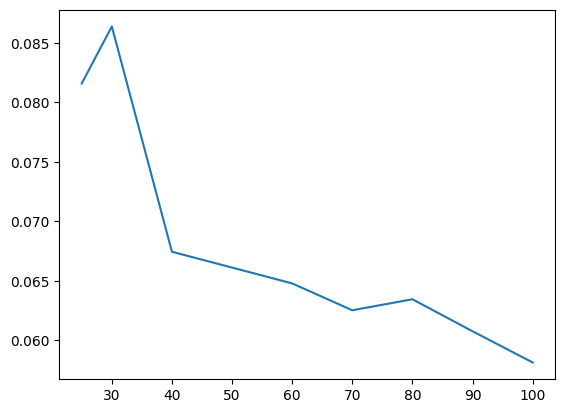

In [22]:
losses = []
numNeuronas = [25,30,40,60,70,80,90,100]
for n in numNeuronas:
    model = tf.keras.models.Sequential(
        [
            Dense(units = n, activation= 'relu'),
            Dense(units=2,activation='sigmoid')
        ]
    )
    model.compile(optimizer=Adam(learning_rate=0.0038), loss='mean_squared_error', metrics=['accuracy'])
    history = model.fit(x_train,y_train,epochs=30,validation_split=0.2)
    losses.append(sum(history.history['val_loss']) / len(history.history['val_loss']))

plt.plot(numNeuronas,losses)
plt.show()

Como podemos observar el primer cambio en el loss lo hace cuando la red se entrena con 40 neuronas, así que cogeremos esa.

Ahora calculamos el numero de neuronas en las capas ocultas, para ello usaremos una regla empírica para aproximar nuestra cantidad de neuronas en las capas ocultas. Siendo M el número de muestras y N el numero de neuronas en la capa de entrada:

- M / 2N <= n <= 2M / N

Aplicándola obtenemos que las neuronas de las capas ocultas van a ser de 4 a 18 neuronas así que utilizamos el mismo procedimiento de la regla del codo para la segunda capa intermedia.

Epoch 1/30
11/11 [==============================] - 1s 8ms/step - loss: 0.2423 - accuracy: 0.5676 - val_loss: 0.2385 - val_accuracy: 0.7791
Epoch 2/30
11/11 [==============================] - 0s 4ms/step - loss: 0.2154 - accuracy: 0.8441 - val_loss: 0.2236 - val_accuracy: 0.7907
Epoch 3/30
11/11 [==============================] - 0s 3ms/step - loss: 0.1872 - accuracy: 0.8412 - val_loss: 0.2079 - val_accuracy: 0.7209
Epoch 4/30
11/11 [==============================] - 0s 2ms/step - loss: 0.1655 - accuracy: 0.8382 - val_loss: 0.1846 - val_accuracy: 0.8721
Epoch 5/30
11/11 [==============================] - 0s 2ms/step - loss: 0.1492 - accuracy: 0.9059 - val_loss: 0.1731 - val_accuracy: 0.8721
Epoch 6/30
11/11 [==============================] - 0s 2ms/step - loss: 0.1390 - accuracy: 0.9235 - val_loss: 0.1658 - val_accuracy: 0.8837
Epoch 7/30
11/11 [==============================] - 0s 2ms/step - loss: 0.1308 - accuracy: 0.9265 - val_loss: 0.1545 - val_accuracy: 0.9070
Epoch 8/30
11/11 [==

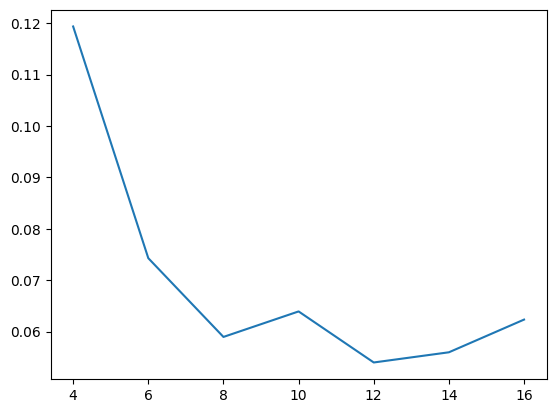

In [25]:
losses = []
numNeuronas = [4,6,8,10,12,14,16]
for n in numNeuronas:
    model = tf.keras.models.Sequential(
        [
            Dense(units = 40, activation= 'relu'),
            Dense(units = n, activation= 'relu'),
            Dense(units=2,activation='sigmoid')
        ]
    )
    model.compile(optimizer=Adam(learning_rate=0.0038), loss='mean_squared_error', metrics=['accuracy'])
    history = model.fit(x_train,y_train,epochs=30,validation_split=0.2)
    losses.append(sum(history.history['val_loss']) / len(history.history['val_loss']))

plt.plot(numNeuronas,losses)
plt.show()

Como podemos observar  el loss cambia cuando se implanta el modelo con 6 neuronas así que escogeremos 6 para la segunda capa.

No hicimos más capas intermedias porque al volver a aplicar la regla del codo en una capa intermedia más ya no bajaba el loss en la gráfica

>### **Entrenando nuestro MLP**

Una vez escogida la arquitectura, a la hora de compilar el modelo escogemos como optimizer `Adam`, la funcion loss `mean_squared_error` y como métricas `accuracy` para poder detectar overfitting

Al entrenar nuestra red podemos ponerle que parte del dataset de entrenamiento lo utilice para validación para ir calculando el error en cada `epoch` e ir ajustando los pesos mejor. (`validation_split`)

Ahora hay que ajustar un poco el `learning_rate` y el numero de entrenamientos(`epoch`). Nos ayudaremos de unas graficas una vez entrenado nuestro modelo para poder evaluar si el entrenamiento ha sido eficiente. Cuando ejecutamos la primera vez el entrenamiento vimos la gráfica que comparaba el accuracy del entrenamiento con el de la validación y nos dimos cuenta de que habia overfitting.

<img src="overfitting.png" width= "50%">

Porque la gráfica daba muchísimos picos y encima la grafica de entrenamiento le seguía perfectamente a la gráfica de validación, eso se debe a que la red ha memorizado el entrenamiento en vez de aprender, ha habido un sobreentrenamiento.

Los picos tan pronunciado se debe a nuestro `learninig_rate` que no es capaz de ajustarse correctamente.

##### **Haciendo muchas pruebas y viendo las graficas de accuracy y loss obtenemos un learning rate y una cantidad de epochs adecuada:**

Y vemos que el accuracy es de 0.9794!!

In [35]:
model = tf.keras.models.Sequential(
        [
            Dense(units = 40, activation= 'relu'),
            Dense(units = 6, activation= 'sigmoid'),
            Dense(units=2,activation='sigmoid')
        ]
    )
model.compile(optimizer=Adam(learning_rate=0.0038), loss='mean_squared_error', metrics=['accuracy'])
history = model.fit(x_train,y_train,epochs=30,validation_split=0.2)

Epoch 1/30
11/11 [==============================] - 0s 8ms/step - loss: 0.3041 - accuracy: 0.6529 - val_loss: 0.2914 - val_accuracy: 0.6860
Epoch 2/30
11/11 [==============================] - 0s 1ms/step - loss: 0.2695 - accuracy: 0.6118 - val_loss: 0.2549 - val_accuracy: 0.6860
Epoch 3/30
11/11 [==============================] - 0s 2ms/step - loss: 0.2466 - accuracy: 0.7059 - val_loss: 0.2284 - val_accuracy: 0.9302
Epoch 4/30
11/11 [==============================] - 0s 2ms/step - loss: 0.2223 - accuracy: 0.8971 - val_loss: 0.2020 - val_accuracy: 0.9186
Epoch 5/30
11/11 [==============================] - 0s 2ms/step - loss: 0.1958 - accuracy: 0.9088 - val_loss: 0.1737 - val_accuracy: 0.9419
Epoch 6/30
11/11 [==============================] - 0s 3ms/step - loss: 0.1714 - accuracy: 0.9265 - val_loss: 0.1480 - val_accuracy: 0.9419
Epoch 7/30
11/11 [==============================] - 0s 2ms/step - loss: 0.1487 - accuracy: 0.9059 - val_loss: 0.1262 - val_accuracy: 0.9302
Epoch 8/30
11/11 [==

>### **Pintado de las graficas**

Codigo:

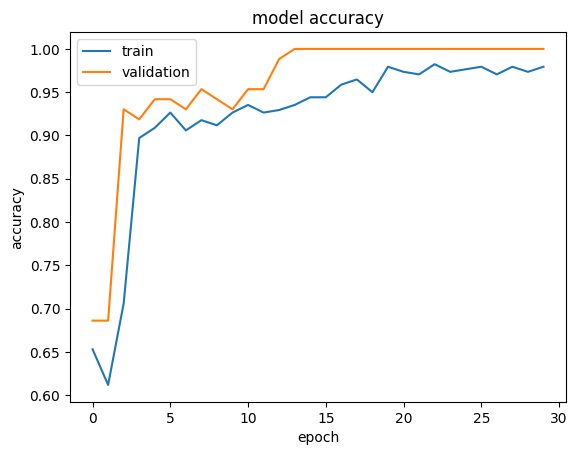

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

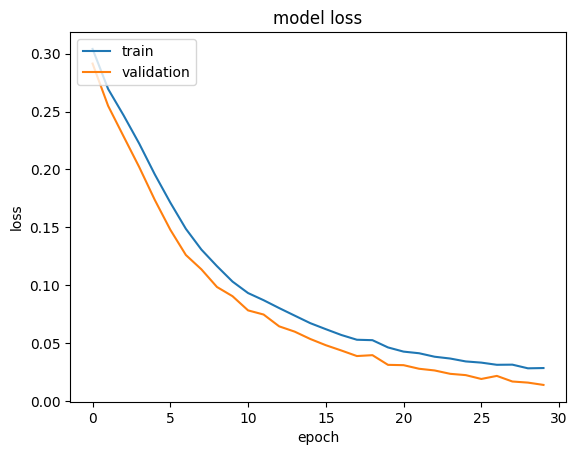

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

>### **Realizamos la predicción sobre el dataset de predicciones**

Y vemos los valores que ha predicho:

In [623]:
y_pred = model.predict(x_test)
y_pred = pd.DataFrame(y_pred)
y_pred.head()
y_pred = np.array(y_pred)
print(len(y_pred))
predicciones = []
for i in range(len(y_pred)):
    predicciones.append(y_pred[i].argmax())

print(predicciones)

5/5 [==============================] - 0s 568us/step
143
[0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0]


>### **Visualicación de matriz de confusión**

La matriz de confusión es una gráfica que mide el numero de errores que ha tenido en la predicción evaluando las predicciones con el dataset de test verdadero. Para ello usaremos la funcion `confusion_matrix` y despues la dibujaremos en un `plot` mediante un objeto llamado `ConfusionMatrixDisplay`

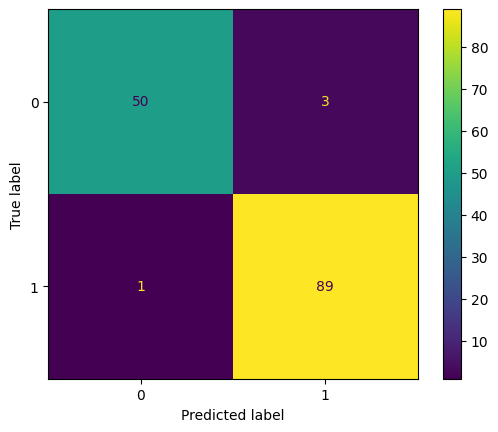

In [625]:
cm = confusion_matrix(y_test, predicciones)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Como podemos observar ha predicho bien 89 tumores Benignos y se ha equivocado en 1 registro y ha acertado 50 tumores Malignos y se ha equivocado en 3 tumores Malignos.